In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [2]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

### Custom pipeline for dat pre-processing

In [3]:
from imblearn.over_sampling import SMOTE
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = 'Binary', smote = False):
        self.label_encode = label_encode
        self.process_label = process_label
        self.smote = smote
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state', 'attack_cat']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label == 'Binary':
            df.drop('attack_cat', axis=1, inplace=True)
        else:             
            df['attack_cat'], df['label'] = df['label'], df['attack_cat']
            df.drop('attack_cat', axis=1, inplace=True)   

        if self.smote:
            # Separate features and labels
            X = df.drop('label', axis=1)
            y = df['label']

            # Apply SMOTE for oversampling
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X, y)

            # Convert NumPy arrays back to Pandas DataFrames
            X_resampled_df = pd.DataFrame(data=X_resampled, columns=X.columns)
            y_resampled_df = pd.DataFrame(data=y_resampled, columns=['label'])

            # Concatenate the features and label columns into a single DataFrame
            df = pd.concat([X_resampled_df, y_resampled_df], axis=1)   

        return df

In [4]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [5]:
pipeline_train = PreProcessPipeline(label_encode=True, process_label='Multi', smote=True)
pipeline_test = PreProcessPipeline(label_encode=True, process_label='Multi')
train_df = pipeline_train.transform(train_df)
test_df = pipeline_test.transform(test_df)

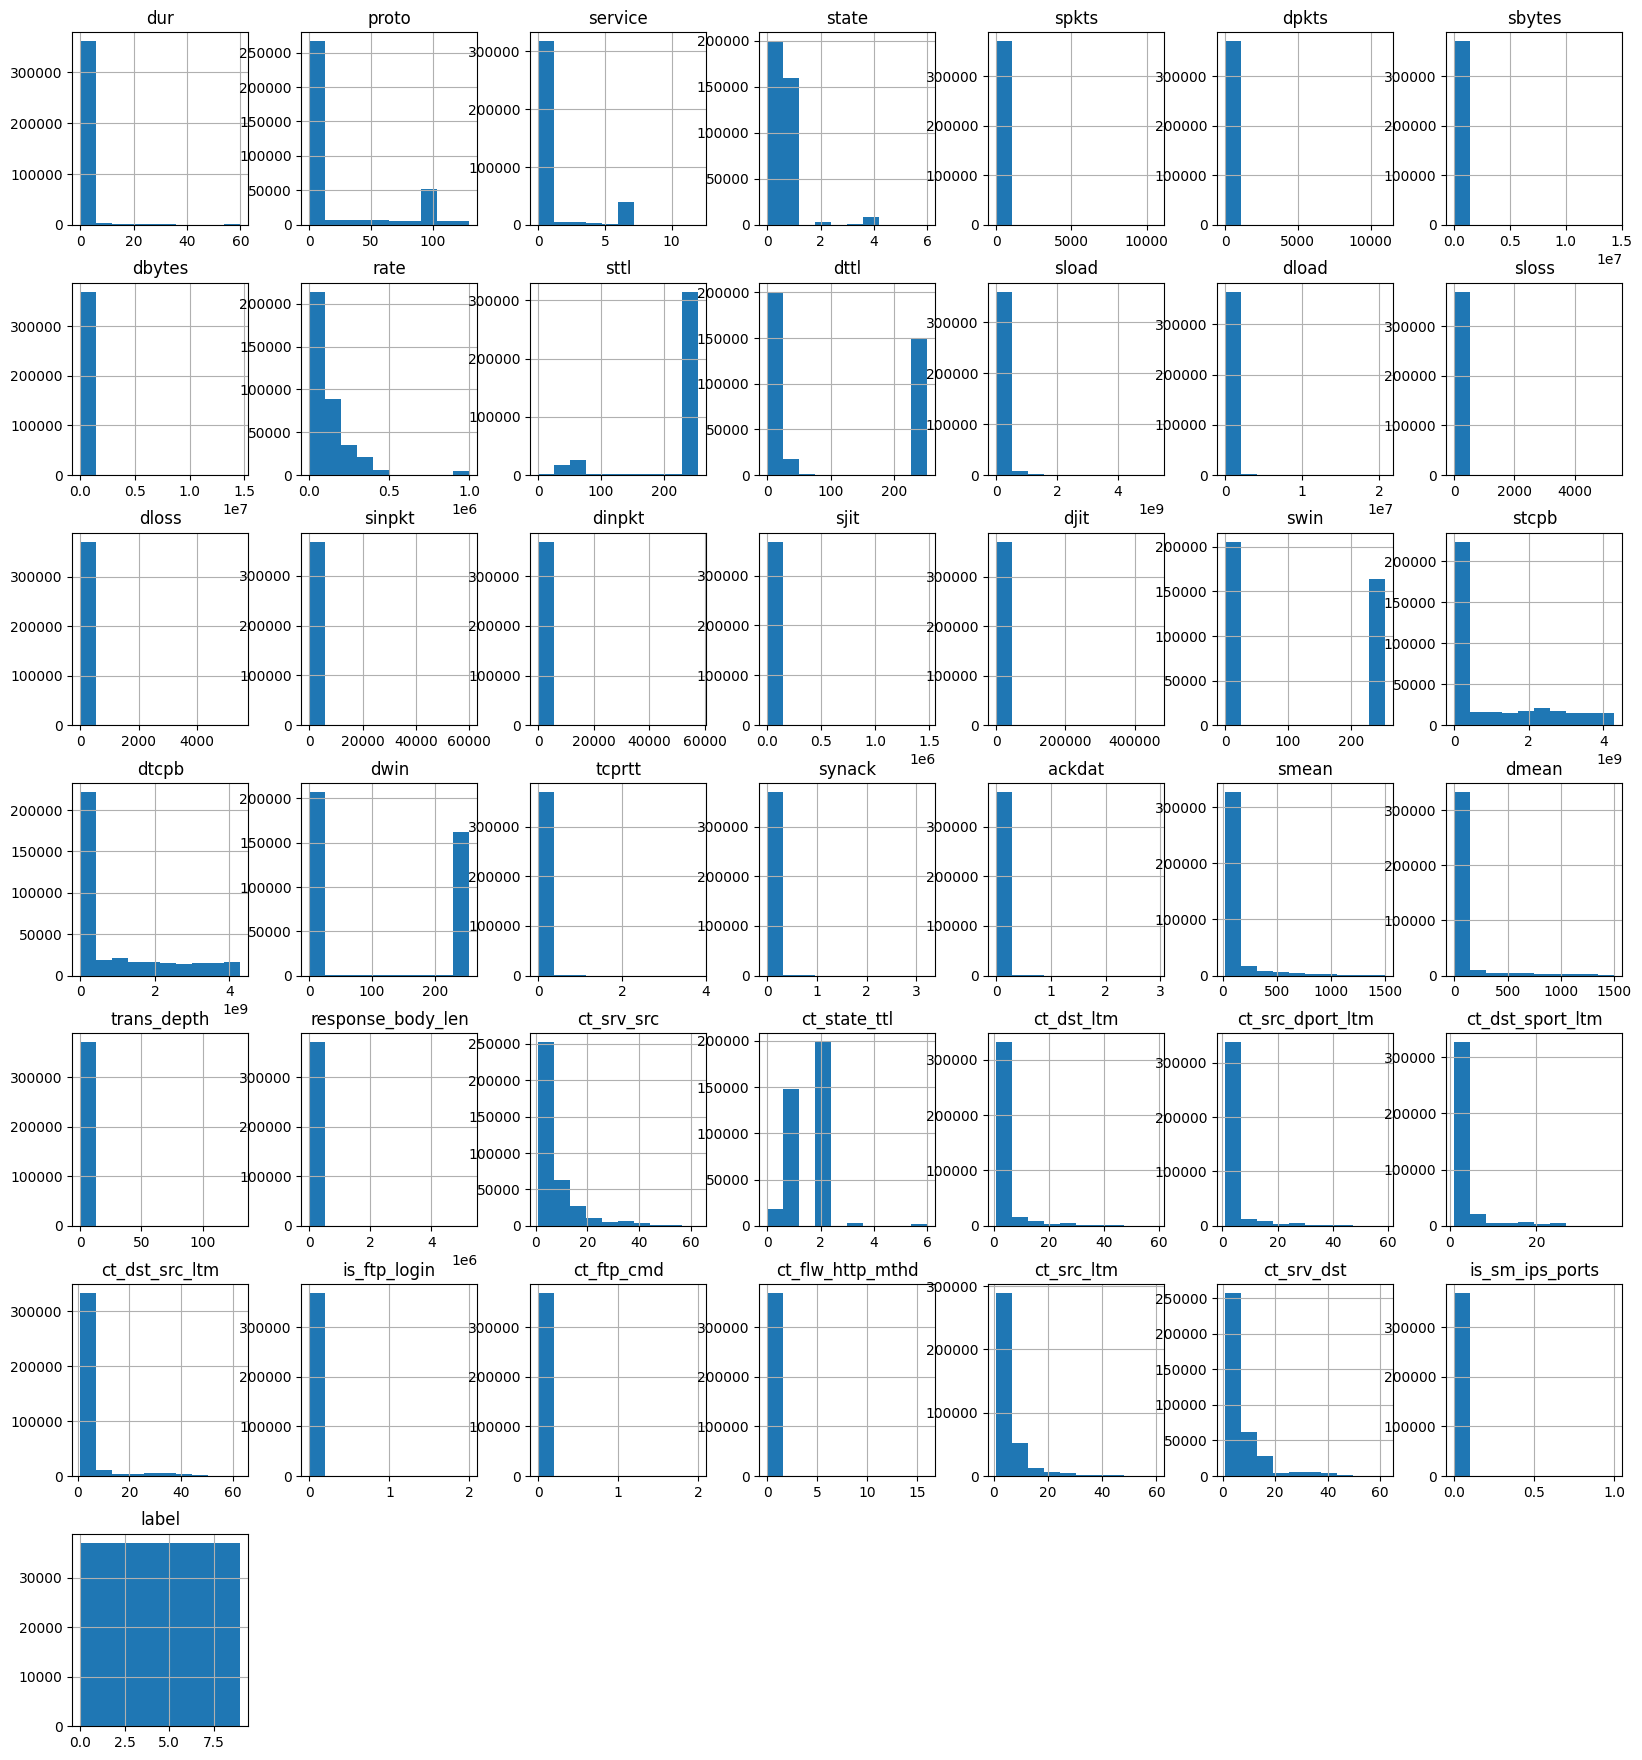

In [6]:
rcParams["figure.figsize"]=(20,22)
train_df.hist()
plt.grid()

In [7]:
spark = SparkSession.builder.appName("CSCI316GP2").getOrCreate()

In [8]:
sparktrain_df = spark.createDataFrame(train_df)
sparktest_df = spark.createDataFrame(test_df)

In [9]:
'''
Author: Khanh Nguyen
Name: PySpark Dataframe Pipeline
Description:
    This class is used to create a pipeline for PySpark dataframe, accept 2 boolean parameter: smote & standardize.
    Features 
        (Default)
        - Resample: Resample the dataframe
        - Vectorize: Vectorize the dataframe
        (activate by setting the parameter to True):
        - SMOTE: Oversampling the minority class
        - Standardize: Standardize the dataframe using z-score
'''

from pyspark.sql.functions import col
class SparkDFPipeline:
    def __init__(self, smote=False, standardize=False):
        self.smote = smote
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):
        if self.smote:
            majority = train_df.filter(col('label') == 0)
            minority = train_df.filter(col('label') == 1)

            majority_count = majority.count()
            minority_count = minority.count()

            ratio = int(majority_count / minority_count)
            sample_num = int(ratio * minority_count) - minority_count
            sample = minority.sample(True, sample_num / minority_count, seed=42)
            balanced_sample = minority.union(sample)
            train_df = majority.union(balanced_sample).orderBy('label')
        
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]
            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            train_df = train_df.select('features', 'label')
            test_df = assembler.transform(test_df)
              
        return train_df, test_df

In [10]:
def evaluate_model(model, val_data):
    # Make predictions on the validation data
    predictions = model.transform(val_data)

    # Evaluate the model using a BinaryClassificationEvaluator for AUC
    auc_evaluator = MulticlassClassificationEvaluator(labelCol='label')
    auc = auc_evaluator.evaluate(predictions)

    # Evaluate the model using a BinaryClassificationEvaluator for areaUnderPR
    pr_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
    area_under_pr = pr_evaluator.evaluate(predictions)

    # Calculate additional metrics
    sensitivity = predictions.filter("label = 1 and prediction = 1").count() / predictions.filter("label = 1").count()
    specificity = predictions.filter("label = 0 and prediction = 0").count() / predictions.filter("label = 0").count()
    precision = predictions.filter("prediction = 1").count() / predictions.filter("prediction = 1 or prediction = 0").count()
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (predictions.filter("label = prediction").count()) / predictions.count()
    # youdens_j = sensitivity + specificity - 1
    # balanced_accuracy = (sensitivity + specificity) / 2

    # Create a dictionary of model evaluation metrics
    eval_metrics = {
        'AUC': auc,
        'AreaUnderPR': area_under_pr,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Accuracy': accuracy,
        # "Youden's J Index": youdens_j,
        # 'Balanced Accuracy': balanced_accuracy
    }

    return eval_metrics

In [11]:
# Pipeline example
pipeline = SparkDFPipeline(smote=False, standardize=True)
train, test = pipeline.transform(sparktrain_df, sparktest_df)

# ANN model

In [12]:
input_length = len(train.select('features').collect()[0][0])
output_length = train.select('label').distinct().count()

In [13]:
'''
mlp = MultilayerPerceptronClassifier(seed=42, maxIter=50, stepSize=0.01)
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

paramGrid = ParamGridBuilder() \
             .addGrid(mlp.layers, [
                    [input_length, 8, 8, output_length],
                    [input_length, 8, 16, output_length],
                    [input_length, 8, 32, output_length],
                    [input_length, 16, 8, output_length],
                    [input_length, 16, 32, output_length],
                    [input_length, 32, 8, output_length],
                    [input_length, 32, 16, output_length],
                    [input_length, 16, 16, output_length],
                    [input_length, 32, 32, output_length],
                 # Add more layer combinations as needed
             ]) \
             .build()

crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

cv_model = crossval.fit(train)
best_model = cv_model.bestModel
best_params = best_model.extractParamMap()
'''

"\nmlp = MultilayerPerceptronClassifier(seed=42, maxIter=50, stepSize=0.01)\nevaluator = MulticlassClassificationEvaluator(metricName='accuracy')\n\nparamGrid = ParamGridBuilder()              .addGrid(mlp.layers, [\n                    [input_length, 8, 8, output_length],\n                    [input_length, 8, 16, output_length],\n                    [input_length, 8, 32, output_length],\n                    [input_length, 16, 8, output_length],\n                    [input_length, 16, 32, output_length],\n                    [input_length, 32, 8, output_length],\n                    [input_length, 32, 16, output_length],\n                    [input_length, 16, 16, output_length],\n                    [input_length, 32, 32, output_length],\n                 # Add more layer combinations as needed\n             ])              .build()\n\ncrossval = CrossValidator(estimator=mlp,\n                          estimatorParamMaps=paramGrid,\n                          evaluator=evaluator,\n   

In [14]:
'''
# 32/16 52
#
# Create a list of parameter names and their corresponding values
param_list = [(param.name, value) for param, value in best_params.items()]

# Convert the list to a formatted string
shortened_output = "\n".join([f"{param}: {value}" for param, value in param_list])

print(shortened_output)
'''

NameError: name 'best_params' is not defined

In [30]:
layers = [input_length, 16, 16, output_length]
mlp = MultilayerPerceptronClassifier(seed=42, maxIter=50, layers=layers, stepSize=0.01, blockSize=128)
mlp_model = mlp.fit(train)
mlp_predictions = mlp_model.transform(test)
mlp_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(mlp_evaluator.evaluate(mlp_predictions)))


Test set accuracy = 0.42088273706663015


In [ ]:
'''
# Make predictions on the validation data
predictions = best_model.transform(test)

    # Evaluate the model using a BinaryClassificationEvaluator for AUC
auc_evaluator = MulticlassClassificationEvaluator(labelCol='label')
auc = auc_evaluator.evaluate(predictions)
auc
'''

0.5276969187031885

In [ ]:
spark.stop()